## Import libraries and dataset

In [45]:
! pip install nltk
! pip install lit-nlp
! pip install umap-learn
! pip install plotly
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
! pip install sentence-transformers
! pip install chromadb
! pip install shap
! pip install transformers

seed=42

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.2
    Uninstalling protobuf-5.29.2:
      Successfully uninstalled protobuf-5.29.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following d

In [46]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import re
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import chromadb
from chromadb.utils import embedding_functions

from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
drive.mount('/content/gdrive')
#file_path = '/content/gdrive/My Drive/'
file_path = '/content/gdrive/My Drive/Colab Notebooks/dataset/'

try:
    data = pd.read_csv(file_path+'all-data.csv', header=None)
    data.columns = ['sentiment', 'text']
    print("File caricato con successo!")
except FileNotFoundError:
    print("Il file non è stato trovato. Assicurati che il percorso sia corretto.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File caricato con successo!


In [48]:
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [49]:
data.shape

(4846, 2)

## Data Storage and Query

### Tokenization

In [50]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    stop_words = stopwords.words('english')
    lower_text = text.lower()                                              
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   
    filtered_text = word_tokenize(filtered_text)                            #
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

In [51]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

In [52]:
data.head()

,sentiment,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...


### Transformer encoding

https://huggingface.co/mrm8488/istilroberta-finetuned-financial-news-sentiment-analysis

The SentenceTransformer with the model 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis' is used to generate sentence embeddings or contextual representations for text data.

# What is distilroberta_model?

- Model Architecture:
  **DistilRoBERTa**, a distilled version of RoBERTa, which is a state-of-the-art transformer-based model. It is lighter and faster while retaining most of the performance of the original RoBERTa.
  **Fine-tuned on financial news sentiment analysis**: The model has been pre-trained and then fine-tuned on a dataset of financial news to classify sentiment (e.g., positive, neutral, negative).

- SentenceTransformer:
  A library specifically designed for generating meaningful vector representations (embeddings) of entire sentences, rather than just individual words or tokens.
  It wraps models like RoBERTa, fine-tuning them to work better for tasks like semantic similarity, clustering, or classification.

- Pre-trained model:
  The specific 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis' model is trained on financial news data. This fine-tuning ensures it captures nuances and semantics relevant to the financial domain.

# Why use this model?

- **Generate Embeddings for Sentences**:
  The SentenceTransformer processes a sentence (or document) and outputs a fixed-size vector (embedding) that captures the sentence's meaning in its context.

- **Sentiment Analysis**:
  The fine-tuning ensures the model can classify the sentiment of financial news articles effectively.
  It can predict whether the sentiment expressed in financial news is positive, neutral, or negative.

- **Financial-Specific Understanding**:
  Models pre-trained and fine-tuned on domain-specific data (e.g., financial news) are more accurate for tasks in that domain compared to general-purpose models.
  For example, phrases like "market surge" or "stock plunge" might carry distinct sentiment connotations in financial contexts.

- **Efficiency**:
  Using a distilled version (DistilRoBERTa) is computationally efficient and well-suited for production environments where speed and scalability are essential.

In [53]:
from sentence_transformers import SentenceTransformer


distilroberta_model = SentenceTransformer('mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')
data['embedding_distilroberta'] = data['text'].apply(lambda x: distilroberta_model.encode(x))
print(data[['text', 'embedding_distilroberta']].head())

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                text  \
0  According to Gran , the company has no plans t...   
1  Technopolis plans to develop in stages an area...   
2  The international electronic industry company ...   
3  With the new production plant the company woul...   
4  According to the company 's updated strategy f...   

                             embedding_distilroberta  
0  [-0.25176865, 0.14430009, 0.03533828, 0.221463...  
1  [-0.34441203, 0.31980085, 0.2198129, -0.287868...  
2  [-0.32723215, -0.4291335, 0.49703875, -0.35996...  
3  [0.01898552, 0.40328538, -0.74886113, -0.45968...  
4  [-0.101210885, 0.44934195, -0.61999387, -0.005...  


In [54]:
data.head()

,sentiment,text,cleaned_text,embedding_distilroberta
0,neutral,"According to Gran , the company has no plans t...",accord gran company plan move production russi...,"[-0.25176865, 0.14430009, 0.03533828, 0.221463..."
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...,"[-0.34441203, 0.31980085, 0.2198129, -0.287868..."
2,negative,The international electronic industry company ...,international electronic industry company elco...,"[-0.32723215, -0.4291335, 0.49703875, -0.35996..."
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,"[0.01898552, 0.40328538, -0.74886113, -0.45968..."
4,positive,According to the company 's updated strategy f...,accord company update strategy year basware ta...,"[-0.101210885, 0.44934195, -0.61999387, -0.005..."


In [55]:
data['embedding_distilroberta'].iloc[0].shape

(768,)

### ChromaDB creation and population

In [60]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRobertaFinal"

client = chromadb.PersistentClient(path=pathDB)  
collections = client.list_collections()
print(collections)

[]


In [61]:
from chromadb.config import Settings


client = chromadb.PersistentClient(
    path=pathDB,  
)

collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)
for index, row in data.iterrows():
    collection.add(
        ids=[str(index)],  
        documents=[row["text"]],
        metadatas=[{
            "sentiment": row["sentiment"],
            "cleaned_text": row["cleaned_text"]
        }], 
        embeddings=[row["embedding_distilroberta"]]  
    )

print("Dataset caricato in ChromaDB con successo!")

Dataset caricato in ChromaDB con successo!


### ChromaDB queries

In [62]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRobertaFinal"

client = chromadb.PersistentClient(path=pathDB)
collections = client.list_collections()
print(collections)

collection_name = "sentiment_embeddings"
collection = client.get_or_create_collection(name=collection_name)

[Collection(name=sentiment_embeddings)]


In [63]:
def search_query(collection, query_text, n_results=3):
    query_embedding = distilroberta_model.encode(query_text)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

In [64]:

queries = [
    "Silicon Valley's impact on global technology development",
    "Positive solutions in renewable energy",
    "Negative controversies in the automotive industry",
    "Political tensions in Asia-Pacific region",
    "Positive news in the stock market",
    "Issues regarding cybersecurity threats in the financial sector",
    "Celebrity endorsements positively influence brand equity"
]

query_results = {}


for query in queries:
    print("*" * 160)
    print(f"\nQuery: {query}")
    results = search_query(collection, query, n_results=3)  

    query_results[query] = []

    
    if 'documents' in results and results['documents']:
        for i, document in enumerate(results['documents']):
            metadata_list = results['metadatas'][i]
            distances = results['distances'][i]

            if isinstance(metadata_list, list):
                for j, metadata in enumerate(metadata_list):
                    entry = {
                        "text": document[j],
                        "gt": metadata.get('sentiment', 'No sentiment found'),
                        "cleaned_text": metadata.get('cleaned_text', 'No cleaned text found'),
                        "distance": distances[j]
                    }
                    query_results[query].append(entry) 


                    print(f"\nDocument {j + 1}:")
                    print(f"Text: {entry['text']}")
                    print(f"Sentiment: {entry['gt']}")
                    print(f"Cleaned Text: {entry['cleaned_text']}")
                    print(f"Distance: {distances[j]:.4f}")
                    print("-" * 50)
            else:
                print(f"Metadata for document {i + 1} is not a list. Skipping...")
    else:
        print("No relevant documents found for this query.")

****************************************************************************************************************************************************************

Query: Silicon Valley's impact on global technology development

Document 1:
Text: The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .
Sentiment: neutral
Cleaned Text: engine asia pacific industry profile essential resource top level data analysis cover engine industry
Distance: 73.3165
--------------------------------------------------

Document 2:
Text: As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .
Sentiment: neutral
Cleaned Text: stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry
Distance: 74.5497
--------------------------------------------------

Doc

## Sentiment Classification

In [65]:
for query in queries:
    print(query_results[query])

[{'text': 'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .', 'gt': 'neutral', 'cleaned_text': 'engine asia pacific industry profile essential resource top level data analysis cover engine industry', 'distance': 73.31651306152344}, {'text': 'As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .', 'gt': 'neutral', 'cleaned_text': 'stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry', 'distance': 74.54969024658203}, {'text': 'Stockholm , 3 March 2011 About Cybercom The Cybercom Group is a high-tech consultancy that offers global sourcing for end-to-end solutions .', 'gt': 'neutral', 'cleaned_text': 'stockholm march cybercom cybercom group high tech consultancy offer global source end end solution', 'distance': 77.38478851

In [66]:
import chromadb
pathDB="/content/gdrive/My Drive/Colab Notebooks/dataset/ChromaDBRoberta"

client = chromadb.PersistentClient(path=pathDB)  
collections = client.list_collections()
print(collections)

[Collection(name=sentiment_embeddings)]


In [67]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

sentiment_classifier = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Device set to use cpu


In [68]:
text_result_query = []
cleaned_text_result_query = []
actual_labels = []
predicted_labels = []

def classify_sentiment(text):
    result = sentiment_classifier(text)[0]  
    return result['label'], result['score']


for query in query_results:
    print(f"\nQuery: {query}")

    results = query_results[query]

    for i, document in enumerate(results):
        text = document['text']
        text_result_query.append(text)
        cleaned_text_result_query.append(document['cleaned_text'])

        classified_sentiment, score = classify_sentiment(text)

        query_results[query][i]['sentiment'] = classified_sentiment
        query_results[query][i]['score'] = score

        actual_labels.append(document['gt'])
        predicted_labels.append(classified_sentiment.lower())

        print(f"Top {i + 1} document:")
        print(f"Text: {text}")
        print(f"Predicted Sentiment: {classified_sentiment}")
        print(f"Score: {score}")
        print(f"Actual Sentiment: {document['sentiment']}")
        print(f"Cleaned Text: {document['cleaned_text']}")
        print("-" * 50)


Query: Silicon Valley's impact on global technology development
Top 1 document:
Text: The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .
Predicted Sentiment: neutral
Score: 0.999894380569458
Actual Sentiment: neutral
Cleaned Text: engine asia pacific industry profile essential resource top level data analysis cover engine industry
--------------------------------------------------
Top 2 document:
Text: As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .
Predicted Sentiment: neutral
Score: 0.9998922348022461
Actual Sentiment: neutral
Cleaned Text: stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry
--------------------------------------------------
Top 3 document:
Text: Stockholm , 3 March 2011 About Cybercom The Cyberc

In [69]:

conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])

report = classification_report(actual_labels, predicted_labels, labels=['positive', 'neutral', 'negative'], zero_division=1)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    positive       0.67      1.00      0.80         6
     neutral       1.00      0.70      0.82        10
    negative       1.00      1.00      1.00         5

    accuracy                           0.86        21
   macro avg       0.89      0.90      0.87        21
weighted avg       0.90      0.86      0.86        21



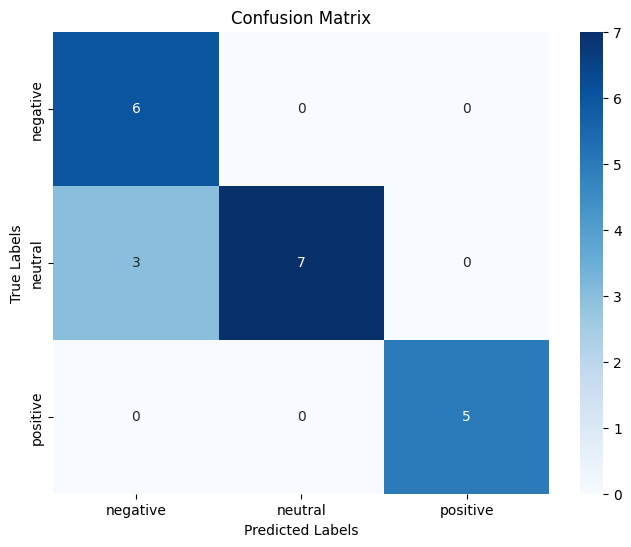

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Explainability

In [ ]:
text_result_query[0]

'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .'

In [ ]:
cleaned_text_result_query[0]

'engine asia pacific industry profile essential resource top level data analysis cover engine industry'

In [ ]:
len(text_result_query), len(cleaned_text_result_query), len(actual_labels), len(predicted_labels)

(21, 21, 21, 21)

In [ ]:
query_results[queries[0]][0]['text']

'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .'

In [ ]:
query_results[queries[0]]

[{'text': 'The Engines in Asia-Pacific industry profile is an essential resource for top-level data and analysis covering the engines industry .',
  'gt': 'neutral',
  'cleaned_text': 'engine asia pacific industry profile essential resource top level data analysis cover engine industry',
  'distance': 73.3165512084961,
  'sentiment': 'neutral',
  'score': 0.999894380569458},
 {'text': 'As with other stakeholders , COMPTEL has been involved in the workshops , meetings and filed comments on the issues of greatest importance to the competitive sector of our industry .',
  'gt': 'neutral',
  'cleaned_text': 'stakeholder comptel involve workshop meeting file comment issue great importance competitive sector industry',
  'distance': 74.5496597290039,
  'sentiment': 'neutral',
  'score': 0.9998922348022461},
 {'text': 'Stockholm , 3 March 2011 About Cybercom The Cybercom Group is a high-tech consultancy that offers global sourcing for end-to-end solutions .',
  'gt': 'neutral',
  'cleaned_tex

The heatmap visualizes the **attention weights** from a transformer model, showing how much attention each token in a text pays to every other token. Here's a breakdown:
- X-axis (horizontal): Represents the source tokens, which are giving attention.

- Y-axis (vertical): Represents the target tokens, which are receiving attention.

Each cell in the matrix, located at row $i$ and column $j$, indicates how much the token $i$ is attending to token $j$. Higher values (lighter colors) mean stronger attention, while lower values (darker colors) mean weaker attention.

The heatmap helps you understand which **tokens influence each other** the most during the model's processing, revealing relationships between words and showing how the model interprets the input text.

When tokenizing input text, the number of tokens you see in the tokenized output may differ from the number of tokens represented in the attention heatmap due to the following reasons:

- The superscripts with `s` (such as `<s>` and `</s>`) that you see in the token list are part of the tokenization system used in Transformer-based models, such as those of Hugging Face. They are special tokens that are automatically added to indicate the beginning and end of a sequence.

- The `G` in front of many tokens, represented as `Ġ`, is a symbol used by tokenizers such as Byte-Pair Encoding (BPE) and other variants (e.g., the one used in RoBERTa). This symbol indicates that the token is preceded by a space in the original text. It is a convention for handling word segmentation and spaces, making the model more efficient in language representation.

Complex or rare words are divided into sub-tokens to reduce the vocabulary of the model and generalise better.
Example:

- `chinafactory` could become [`china`, `Ġfactory`]

In [71]:
df = pd.DataFrame()
for query in query_results:
  queries = [query, query, query]
  df_tmp = pd.DataFrame(query_results[query])
  df_tmp['query'] = queries
  df = pd.concat([df, df_tmp])

df = df.reset_index(drop=True)
df.head()

,text,gt,cleaned_text,distance,sentiment,score,query
0,The Engines in Asia-Pacific industry profile i...,neutral,engine asia pacific industry profile essential...,73.316513,neutral,0.999894,Silicon Valley's impact on global technology d...
1,"As with other stakeholders , COMPTEL has been ...",neutral,stakeholder comptel involve workshop meeting f...,74.549690,neutral,0.999892,Silicon Valley's impact on global technology d...
2,"Stockholm , 3 March 2011 About Cybercom The Cy...",neutral,stockholm march cybercom cybercom group high t...,77.384789,neutral,0.999894,Silicon Valley's impact on global technology d...
3,The GeoSolutions team further provides an intr...,neutral,geosolutions team provide intrigue new technol...,125.130394,positive,0.988056,Positive solutions in renewable energy
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive,financing aspocomp growth aspocomp aggressivel...,126.902588,positive,0.993066,Positive solutions in renewable energy


In [72]:
df.to_csv('query_results.csv', index=False)

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

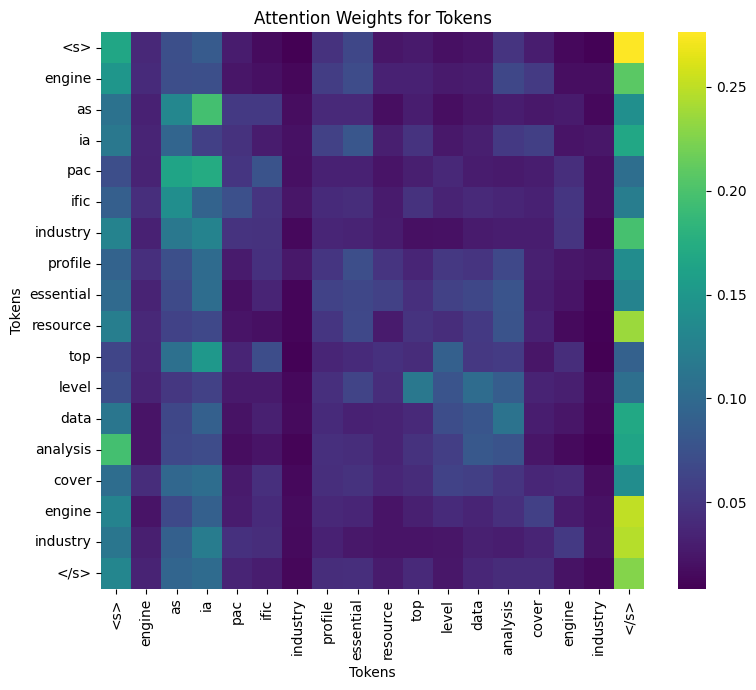

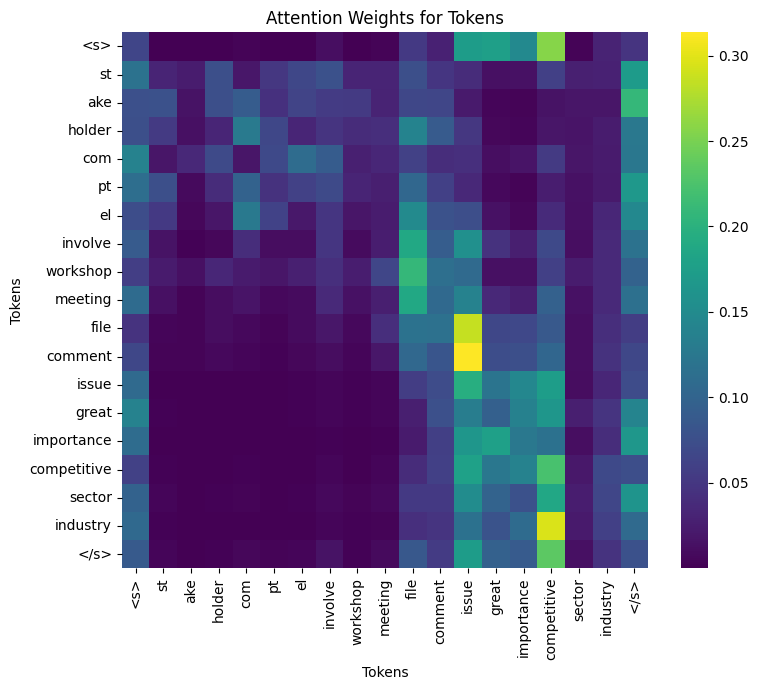

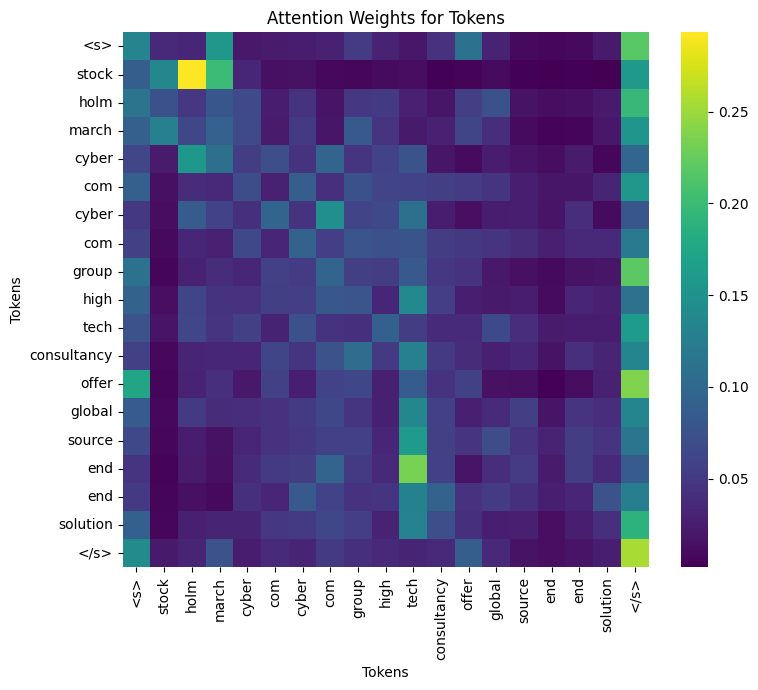

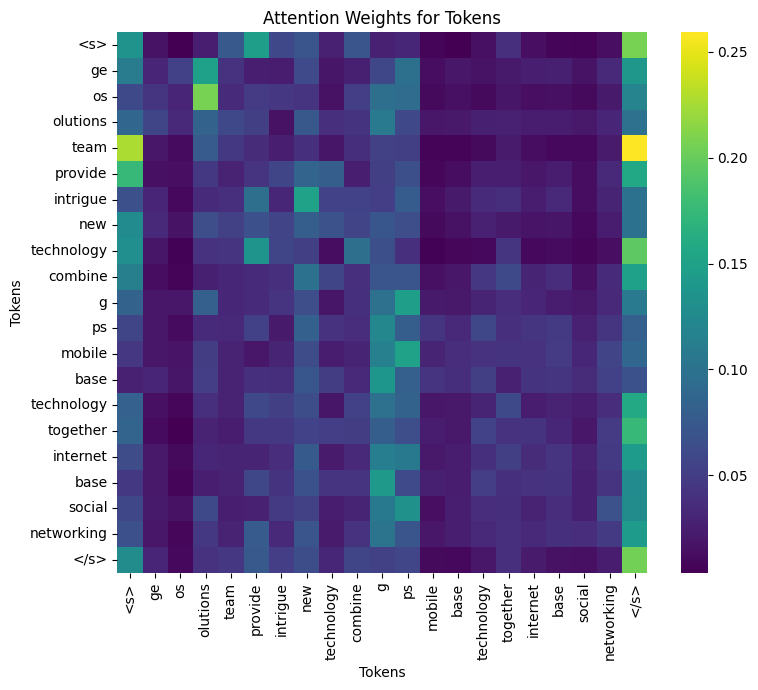

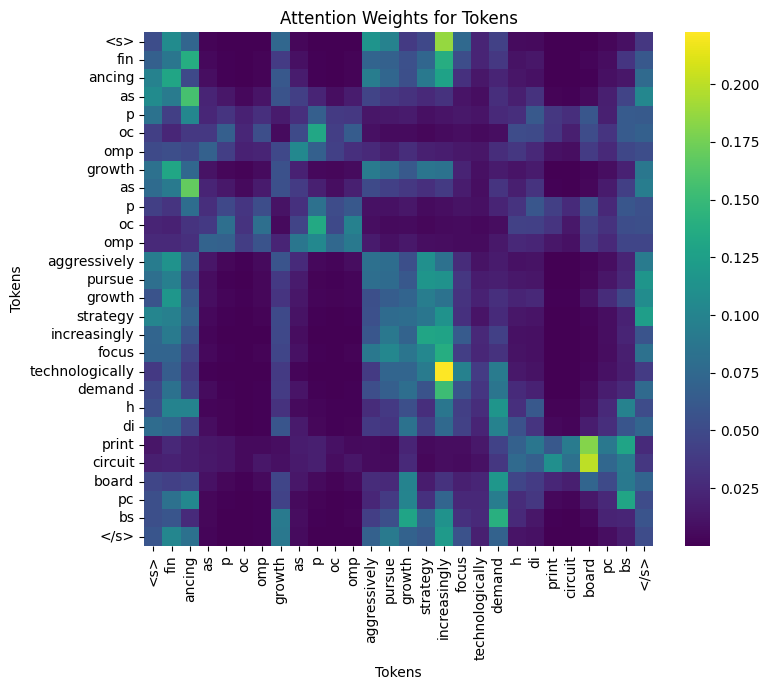

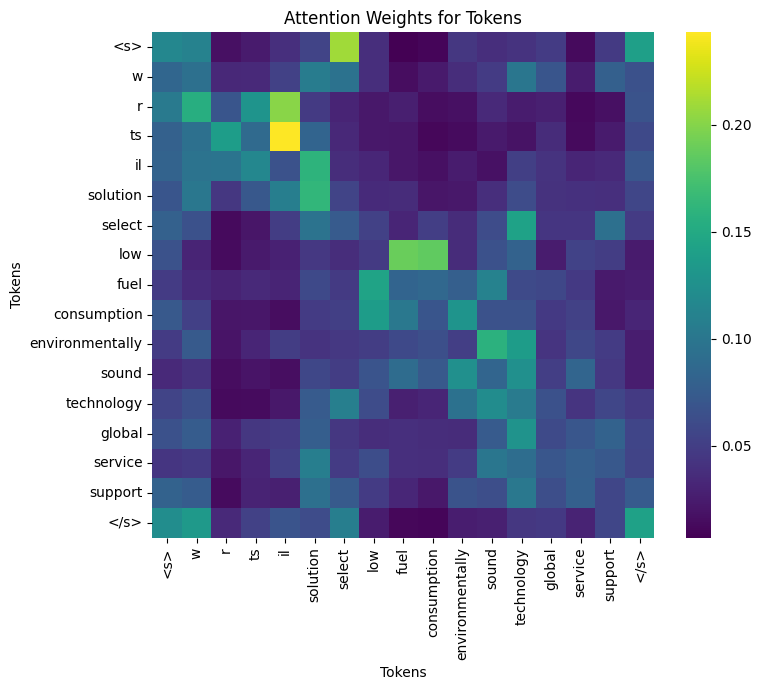

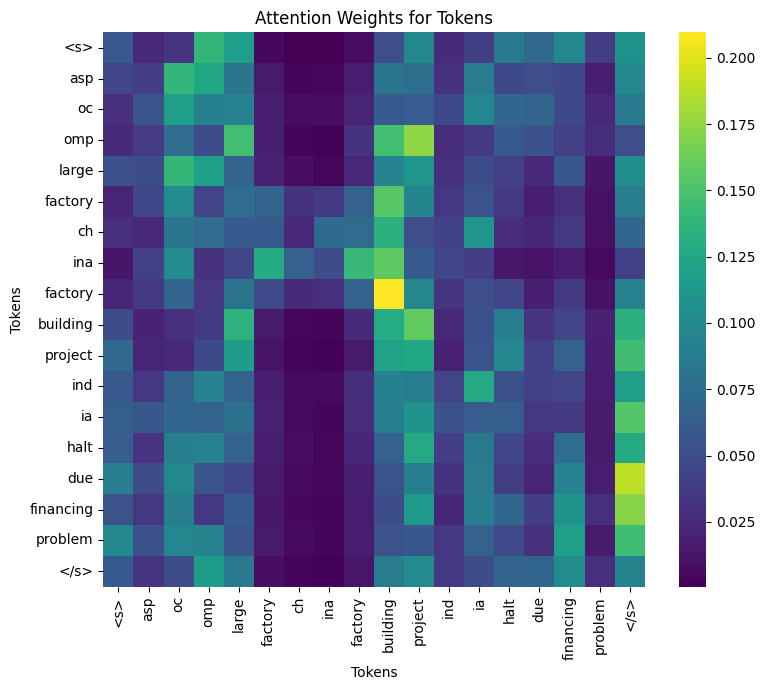

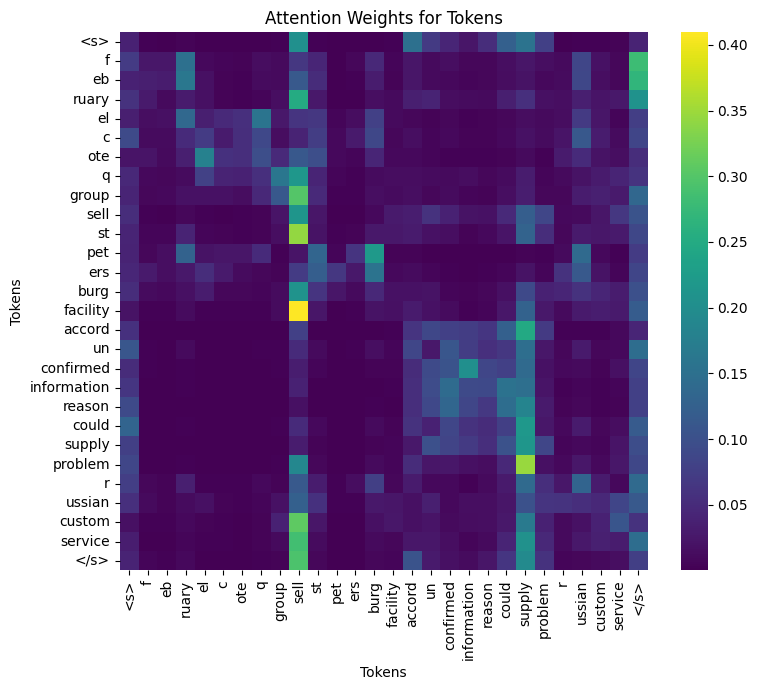

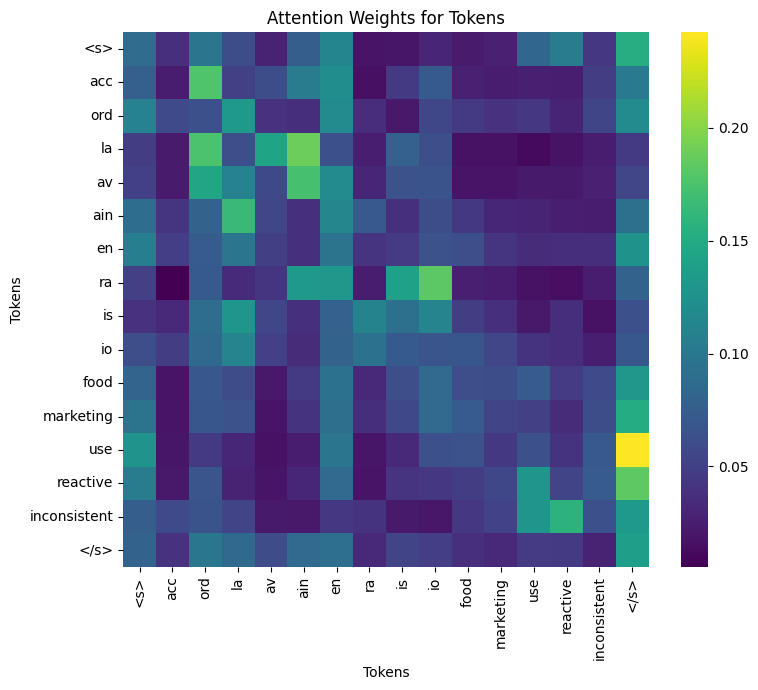

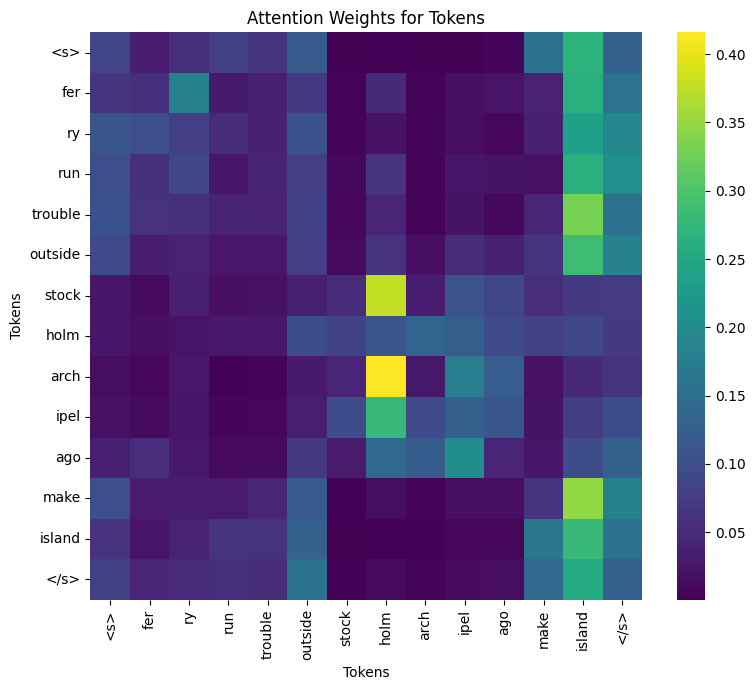

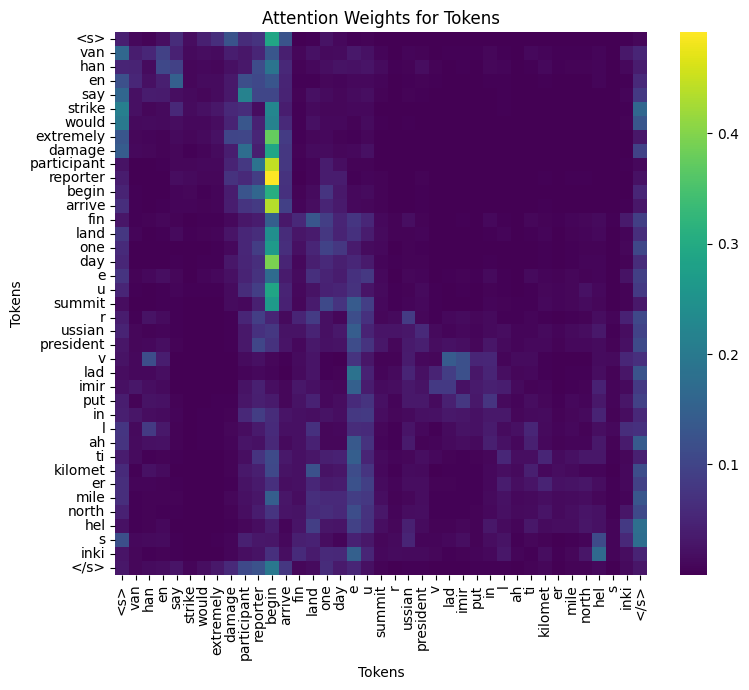

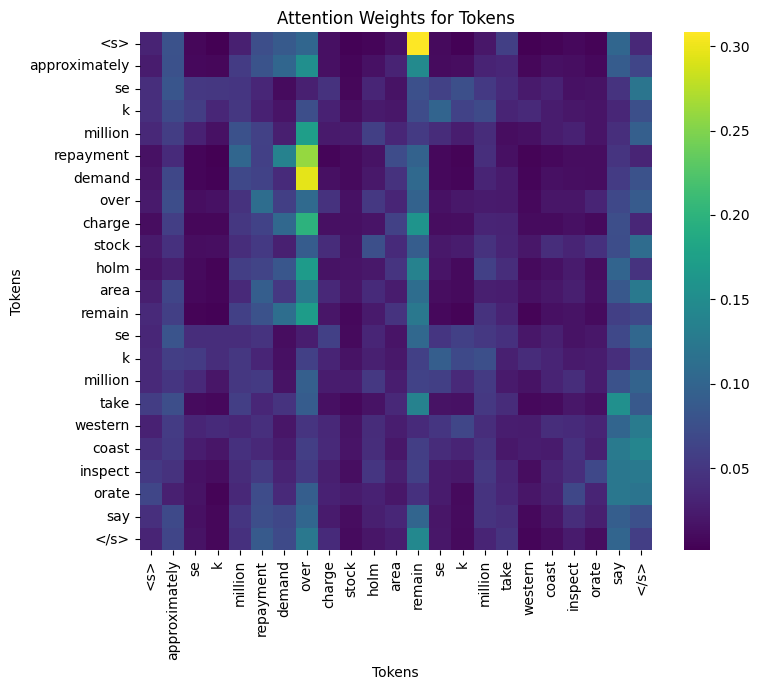

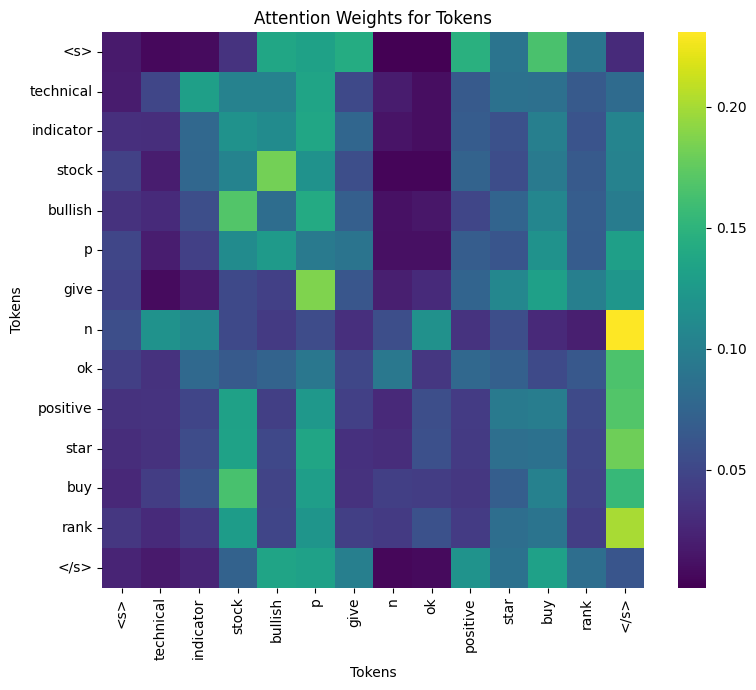

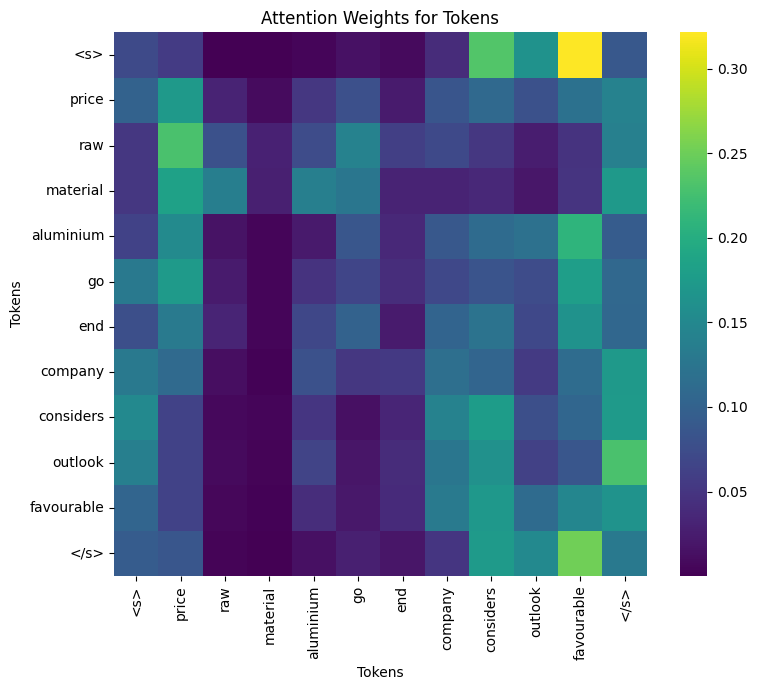

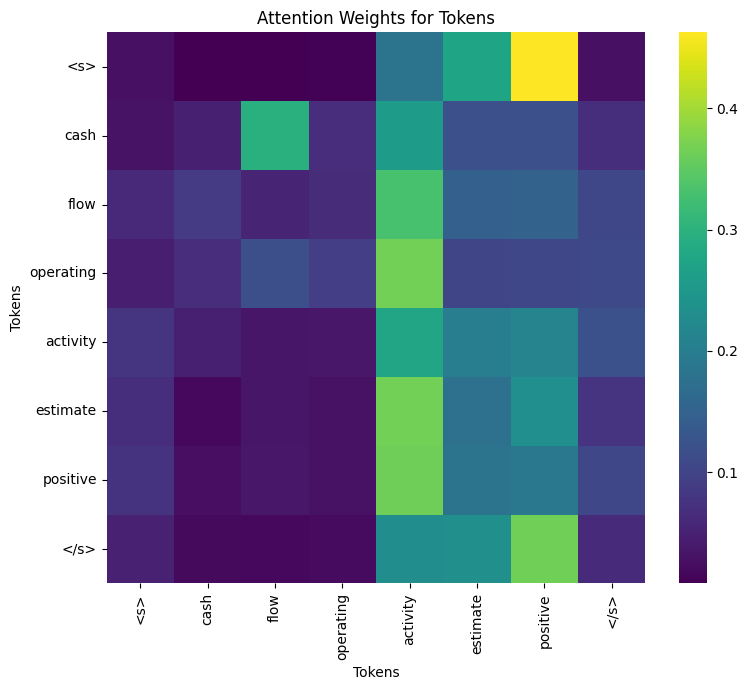

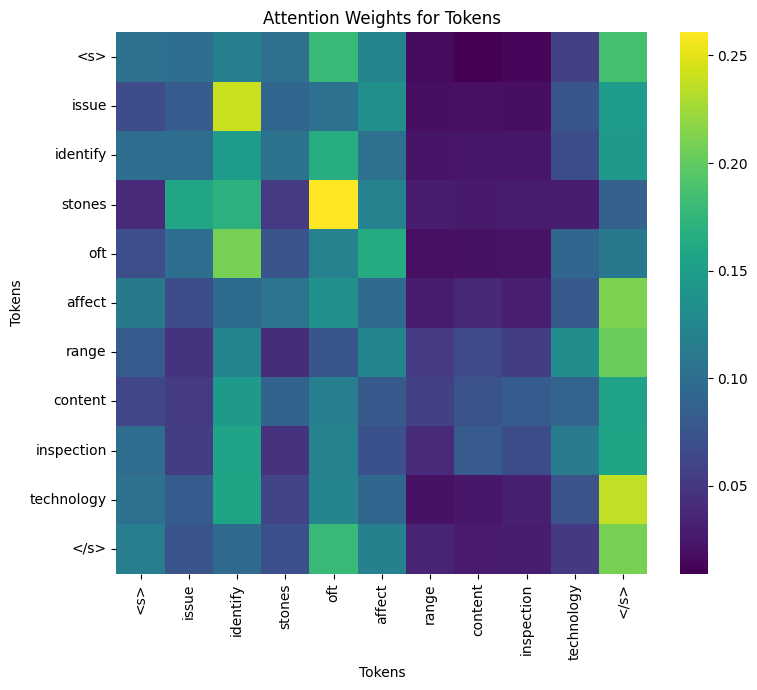

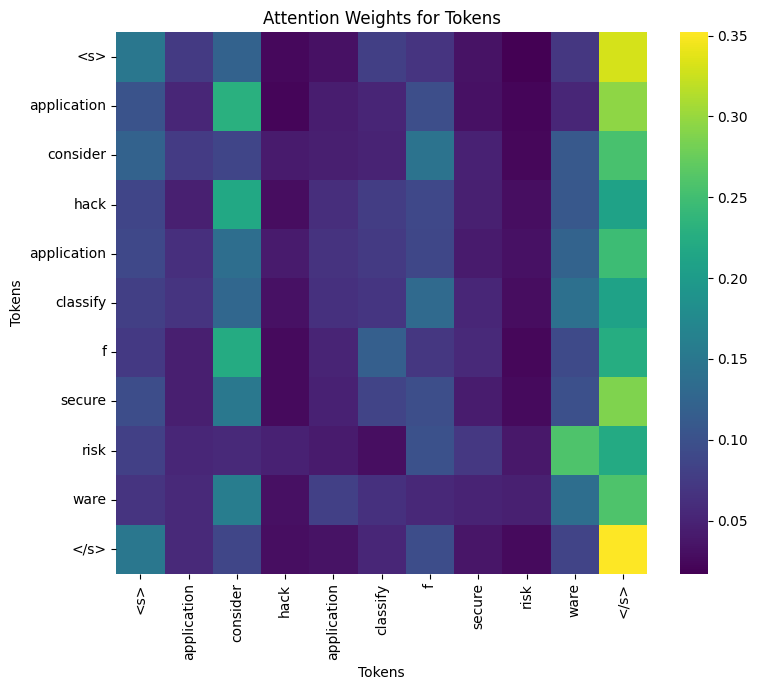

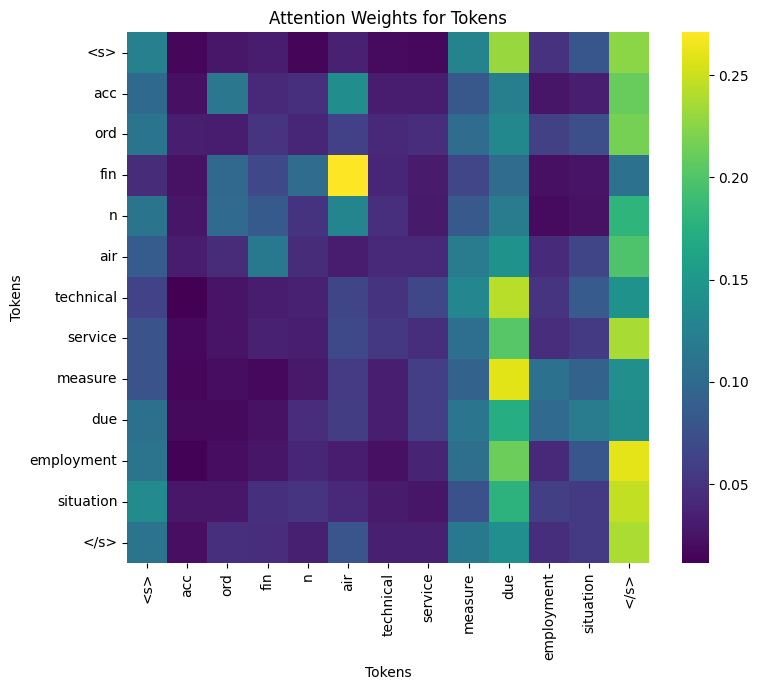

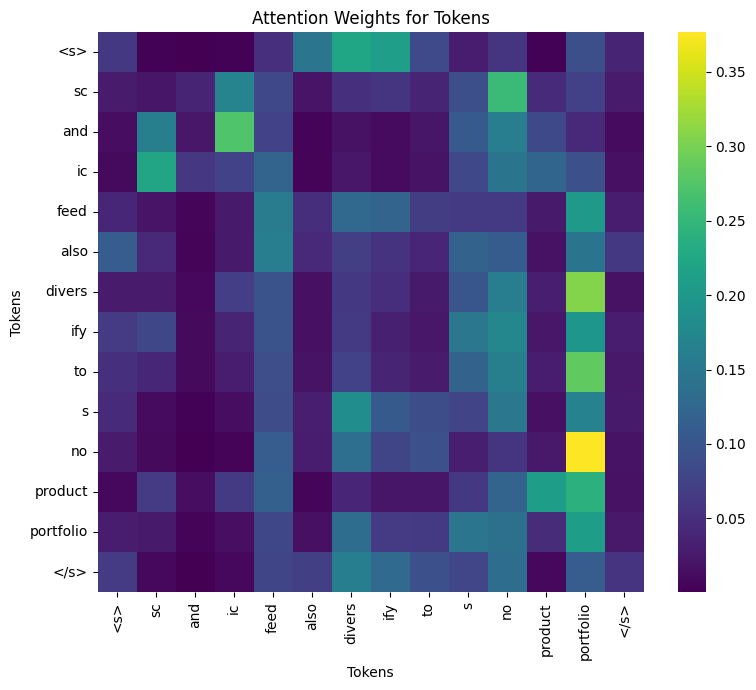

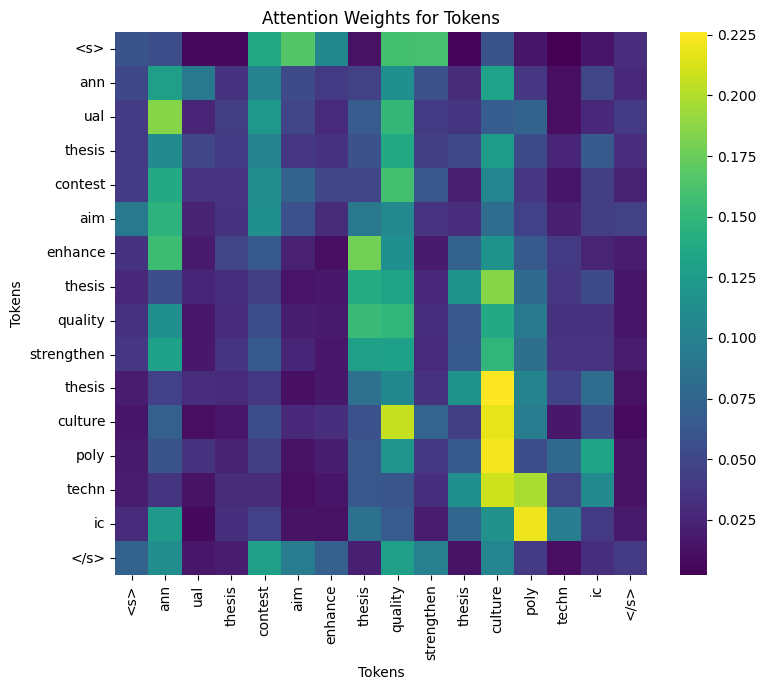

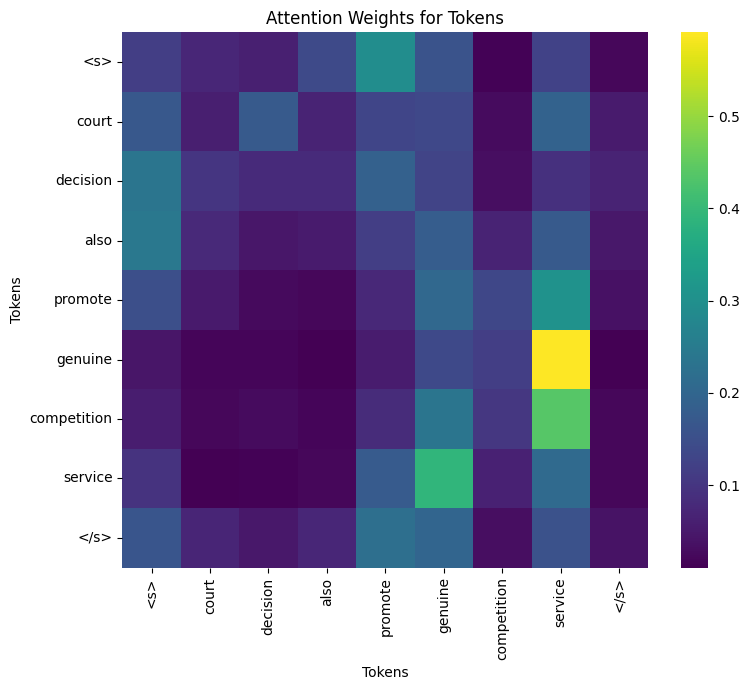

In [73]:
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

for index in range(21):
  model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
  tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

  inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True)
  tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

  clean_tokens = [token.replace("Ġ", "") for token in tokens]

  outputs = model(**inputs)
  attentions = outputs.attentions  

  last_layer_attention = attentions[-1][0][0].detach().numpy()

  plt.figure(figsize=(8, 7))
  sns.heatmap(last_layer_attention, xticklabels=clean_tokens, yticklabels=clean_tokens, cmap="viridis", cbar=True)
  plt.title("Attention Weights for Tokens")
  plt.xlabel("Tokens")
  plt.ylabel("Tokens")
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.savefig(f'attention_heatmap{index}.png')


This following piece of code analyzes the attention weights of a transformer model to identify which tokens in the input text are most relevant to the model's decision-making process. The model generates attention scores for each token, showing how much focus it gives to other tokens. These scores are averaged across attention heads and summed for each token to determine its relevance. The top tokens with the highest attention scores are printed and visualized in a bar plot, showing which parts of the text most influence the model's output.

The attention weights from the last layer are typically averaged across all attention heads to simplify the interpretation. Each attention head learns different aspects of the input, and averaging them provides a more generalized view of which tokens the model deems most important for its final decision. This averaged attention gives a clearer, less noisy understanding of the model's focus, helping to identify key tokens influencing the prediction.

In [76]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for index in range(21):
    model = AutoModel.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", output_attentions=True)
    tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

    inputs = tokenizer(cleaned_text_result_query[index], return_tensors="pt", truncation=True, return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping")  
    outputs = model(**inputs)
    attentions = outputs.attentions

    last_layer_attention = attentions[-1]  
    avg_attention = last_layer_attention.mean(dim=1)  

    token_relevance = avg_attention[0].sum(dim=0).detach().numpy()  

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    clean_tokens = [token.replace("Ġ", "") for token in tokens]

    
    token_with_relevance = list(zip(clean_tokens, token_relevance))
    sorted_tokens = sorted(token_with_relevance, key=lambda x: x[1], reverse=True)

    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=[t[1] for t in sorted_tokens[:10]], y=[t[0] for t in sorted_tokens[:10]])
    plt.title(f"Top 10 Tokens by Attention - Sentence {index}")
    plt.xlabel("Attention Score")
    plt.ylabel("Token")

    plt.savefig(f'attention_barplot_{index}.png')
    plt.close()  

Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it

# Transformer Interpret (HugginFace)

https://github.com/cdpierse/transformers-interpret

In [77]:
!pip install transformers_interpret
from transformers_interpret import SequenceClassificationExplainer
from transformers_interpret import MultiLabelClassificationExplainer

In [78]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

multiclass_explainer = MultiLabelClassificationExplainer(model=model, tokenizer=tokenizer)

In [79]:
for index in range(21):
  word_attributions = multiclass_explainer(text=cleaned_text_result_query[index])
  multiclass_explainer.predicted_class_name
  html = multiclass_explainer.visualize()
  with open(f'transformer_interpret{index}.html', 'w') as f:
    f.write(html.data)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.05),negative,-2.46,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s
n/a,(1.00),neutral,2.94,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s
n/a,(0.04),positive,-1.89,#s engine as ia pac ific industry profile essential resource top level data analysis cover engine industry #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.02),negative,-1.83,#s st ake holder com pt el involve workshop meeting file comment issue great importance competitive sector industry #/s
n/a,(0.89),neutral,-0.22,#s st ake holder com pt el involve workshop meeting file comment issue great importance competitive sector industry #/s
n/a,(0.90),positive,1.99,#s st ake holder com pt el involve workshop meeting file comment issue great importance competitive sector industry #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.05),negative,-3.10,#s stock holm march cyber com cyber com group high tech consultancy offer global source end end solution #/s
n/a,(1.00),neutral,3.41,#s stock holm march cyber com cyber com group high tech consultancy offer global source end end solution #/s
n/a,(0.05),positive,1.11,#s stock holm march cyber com cyber com group high tech consultancy offer global source end end solution #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.04),negative,-2.48,#s ge os olutions team provide intrigue new technology combine g ps mobile base technology together internet base social networking #/s
n/a,(1.00),neutral,1.91,#s ge os olutions team provide intrigue new technology combine g ps mobile base technology together internet base social networking #/s
n/a,(0.08),positive,2.23,#s ge os olutions team provide intrigue new technology combine g ps mobile base technology together internet base social networking #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.03),negative,-2.41,#s w r ts il solution select low fuel consumption environmentally sound technology global service support #/s
n/a,(1.00),neutral,-0.49,#s w r ts il solution select low fuel consumption environmentally sound technology global service support #/s
n/a,(0.13),positive,0.73,#s w r ts il solution select low fuel consumption environmentally sound technology global service support #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.98),negative,1.89,#s asp oc omp large factory ch ina factory building project ind ia halt due financing problem #/s
n/a,(0.35),neutral,-2.27,#s asp oc omp large factory ch ina factory building project ind ia halt due financing problem #/s
n/a,(0.03),positive,-1.56,#s asp oc omp large factory ch ina factory building project ind ia halt due financing problem #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.05),negative,-2.52,#s acc ord la av ain en ra is io food marketing use reactive inconsistent #/s
n/a,(1.00),neutral,1.33,#s acc ord la av ain en ra is io food marketing use reactive inconsistent #/s
n/a,(0.04),positive,-0.24,#s acc ord la av ain en ra is io food marketing use reactive inconsistent #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.98),negative,1.71,#s fer ry run trouble outside stock holm arch ipel ago make island #/s
n/a,(0.39),neutral,-2.18,#s fer ry run trouble outside stock holm arch ipel ago make island #/s
n/a,(0.02),positive,-1.30,#s fer ry run trouble outside stock holm arch ipel ago make island #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.09),negative,1.55,#s approximately se k million repayment demand over charge stock holm area remain se k million take western coast inspect orate say #/s
n/a,(1.00),neutral,-1.16,#s approximately se k million repayment demand over charge stock holm area remain se k million take western coast inspect orate say #/s
n/a,(0.03),positive,-2.74,#s approximately se k million repayment demand over charge stock holm area remain se k million take western coast inspect orate say #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.08),negative,1.15,#s technical indicator stock bullish p give n ok positive star buy rank #/s
n/a,(0.05),neutral,-2.21,#s technical indicator stock bullish p give n ok positive star buy rank #/s
n/a,(1.00),positive,2.31,#s technical indicator stock bullish p give n ok positive star buy rank #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.10),negative,2.28,#s price raw material aluminium go end company considers outlook favourable #/s
n/a,(0.04),neutral,-2.00,#s price raw material aluminium go end company considers outlook favourable #/s
n/a,(1.00),positive,1.82,#s price raw material aluminium go end company considers outlook favourable #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.09),negative,1.06,#s cash flow operating activity estimate positive #/s
n/a,(0.04),neutral,-1.38,#s cash flow operating activity estimate positive #/s
n/a,(1.00),positive,1.40,#s cash flow operating activity estimate positive #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.07),negative,0.89,#s issue identify stones oft affect range content inspection technology #/s
n/a,(1.00),neutral,2.25,#s issue identify stones oft affect range content inspection technology #/s
n/a,(0.03),positive,-2.12,#s issue identify stones oft affect range content inspection technology #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.06),negative,-0.45,#s application consider hack application classify f secure risk ware #/s
n/a,(1.00),neutral,2.16,#s application consider hack application classify f secure risk ware #/s
n/a,(0.04),positive,-0.83,#s application consider hack application classify f secure risk ware #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.12),negative,1.39,#s acc ord fin n air technical service measure due employment situation #/s
n/a,(1.00),neutral,-1.08,#s acc ord fin n air technical service measure due employment situation #/s
n/a,(0.02),positive,-2.39,#s acc ord fin n air technical service measure due employment situation #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.04),negative,-1.49,#s sc and ic feed also divers ify to s no product portfolio #/s
n/a,(0.12),neutral,-2.08,#s sc and ic feed also divers ify to s no product portfolio #/s
n/a,(1.00),positive,1.97,#s sc and ic feed also divers ify to s no product portfolio #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.06),negative,-0.57,#s ann ual thesis contest aim enhance thesis quality strengthen thesis culture poly techn ic #/s
n/a,(0.06),neutral,-2.10,#s ann ual thesis contest aim enhance thesis quality strengthen thesis culture poly techn ic #/s
n/a,(1.00),positive,1.93,#s ann ual thesis contest aim enhance thesis quality strengthen thesis culture poly techn ic #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.05),negative,-0.76,#s court decision also promote genuine competition service #/s
n/a,(0.13),neutral,-2.44,#s court decision also promote genuine competition service #/s
n/a,(0.99),positive,2.14,#s court decision also promote genuine competition service #/s


In [80]:
import os
import shutil


source_dir = "/content"
destination_dir = "/content/my_folder/resultsBI"
os.makedirs(destination_dir, exist_ok=True)
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    if os.path.isfile(file_path):  
        shutil.move(file_path, destination_dir)

print(f"All files moved to {destination_dir}, directories excluded.")

All files moved to /content/my_folder/resultsBI, directories excluded.
